## Word-level language model

In the previous tasks you have written character-level language model. Time has come to grow up.

Word language models face a lot of new problems for you to solve. There are some of them:
  * How to read long texts (Gbs of data)
  * How to build vocabulry (and to effectively reduce its size)
  * How to deal with out-of-vocabulary (OOV) words # random vectors?
  * How to construct batch of _uncorrelated_ examples (not from the same text)
  * How and when to drop RNN state
  * What special tokens should be used? BOS? EOS?

**Results of this task:**
  * Text preprocessing
  * Batcher
  * Trained language model:
    * model should use truncated backpropagation through time
    * model should drop RNN state between different documents (eg. wikipedia articles)
  * Test set perplexity

**Additional points:**
  * Text preprocessing and batching that works with large files (does not load all the file to memory)
  * AWD-LSTM or other uncommon RNN architectures (SRU, QRNN)
  * Use popular dataset 

It is becoming common to use [byte-pair encoding](https://github.com/google/sentencepiece) to solve vocabulary problem. Use it! Here is an [example](https://github.com/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb).

In [81]:
!pip install sentencepiece

In [0]:
import sentencepiece as spm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
import torch.utils.data as utils
import time
import csv
import pandas as pd
import time
import math
from torch.optim.lr_scheduler import StepLR

In [83]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Download & preprocess. Here sentencepiece + vocabulary restriction is used. Only tokens with 200+ frequency contains in vocabulary.
I get data from economic news articles. Contributors read snippets of news articles. Dataset contains these artilces as well as the dates, source titles, and text. Dates range from 1951 to 2014.

In [5]:
!wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Full-Economic-News-DFE-839861.csv

--2019-04-13 14:28:15--  https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Full-Economic-News-DFE-839861.csv
Resolving d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)... 13.35.115.27, 13.35.115.24, 13.35.115.97, ...
Connecting to d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)|13.35.115.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [application/octet-stream]
Saving to: ‘Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  45.7MB/s    in 0.3s    

2019-04-13 14:28:15 (45.7 MB/s) - ‘Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]



In [0]:
df = pd.read_csv('Full-Economic-News-DFE-839861.csv',encoding='latin-1')
all_texts = df['text'] #you can also use df['column_name']

In [0]:
all_texts = all_texts[0:1000]

In [86]:
len(all_texts)

1000

In [87]:
print('Longest text consists of {} symbols'.format(max([len(i) for i in all_texts])))
print('Shortest text consists of {} symbols'.format(min([len(i) for i in all_texts])))
print('Average text consists of {} symbols'.format(int(np.average([len(i) for i in all_texts]))))

Longest text consists of 4988 symbols
Shortest text consists of 113 symbols
Average text consists of 1378 symbols


Download all texts in text.txt, later use in sentensepiecetrainer

In [0]:
myfile = open('text.txt', 'w')
for line in all_texts:
    myfile.write("%s\n" % line.lower().replace('</br></br>',' '))
myfile.close()

In [89]:
spm.SentencePieceTrainer.train('--input=text.txt --model_prefix=m --vocab_size=2000')
sp = spm.SentencePieceProcessor()
sp.load('m.model')
# Gets all tokens as Python list.
vocabs = [sp.id_to_piece(id) for id in range(sp.get_piece_size())]
print('Vocab consists of {} words'.format(len(vocabs)))

Vocab consists of 2000 words


Compute the frequency of each token in the training data.

In [0]:
freq = {}
with open('text.txt', 'r') as f:
    for line in f:
        line = line.rstrip()
        for piece in sp.encode_as_pieces(line):
            freq.setdefault(piece, 0)
            freq[piece] += 1

Let's reduce the vocabulary, only words with frequency more than 200 remain, only $\sim 300+$ words remain.

If the subword would be unknown, "UNK"  token would be used

In [91]:
s = 0
for i in freq:
    if freq[i] > 200:
        s += 1
print(s)

312


In [92]:
print(sp.encode_as_pieces('this is a test.'))
print(sp.encode_as_pieces('hello world football putin russia'))
print(len(vocabs))
vocabs = list(filter(lambda x : x in freq and freq[x] > 200, vocabs))
sp.set_vocabulary(vocabs)
print(sp.encode_as_ids('this is a test.'))
print(sp.encode_as_pieces('hello world football putin russia'))
print(len(vocabs))

['▁this', '▁is', '▁a', '▁t', 'est', '.']
['▁he', 'll', 'o', '▁world', '▁f', 'o', 'o', 't', 'b', 'all', '▁put', 'in', '▁ru', 's', 's', 'ia']
2000
[68, 24, 7, 177, 211, 4]
['▁he', 'll', 'o', '▁w', 'or', 'l', 'd', '▁f', 'o', 'o', 't', 'b', 'al', 'l', '▁p', 'ut', 'in', '▁', 'r', 'us', 's', 'i', 'a']
312


In [93]:
vocabs.append('<UNK>')
vocabs.sort()
print(vocabs)

['"', '&', "'", ')', ',', '-', '.', '."', '0', '1', '2', '3', '4', '5', '5%', '6', '7', '8', '9', ':', '<UNK>', 'a', 'able', 'age', 'al', 'an', 'and', 'ar', 'as', 'at', 'ate', 'ation', 'b', 'c', 'ce', 'ch', 'ck', 'com', 'd', 'e', 'ed', 'el', 'en', 'end', 'ent', 'er', 'ers', 'es', 'est', 'et', 'f', 'g', 'h', 'ha', 'hi', 'i', 'ic', 'id', 'if', 'ight', 'il', 'im', 'in', 'ing', 'ion', 'ir', 'is', 'ist', 'it', 'ity', 'ive', 'k', 'l', 'la', 'le', 'li', 'll', 'lo', 'ly', 'm', 'man', 'many', 'ment', 'min', 'n', 'ne', 'o', 'ol', 'on', 'or', 'p', 'qu', 'r', 'ra', 're', 'ri', 'ro', 's', 'se', 'st', 't', 'ter', 'term', 'th', 'the', 'ting', 'u', 'ul', 'um', 'un', 'ure', 'us', 'ut', 'v', 've', 'ver', 'w', 'x', 'y', 'year', 'z', '▁', '▁"', '▁$1', '▁(', '▁--', '▁0.', '▁1.', '▁19', '▁2', '▁3', '▁4', '▁5', '▁a', '▁about', '▁after', '▁against', '▁al', '▁all', '▁also', '▁an', '▁analysts', '▁and', '▁are', '▁as', '▁at', '▁average', '▁b', '▁back', '▁bank', '▁banks', '▁be', '▁because', '▁been', '▁billion', '▁

Create own dict of indexes of words from vocab + reversed

In [0]:
idx_2_word = dict(enumerate(vocabs))
word_2_idx = {v: k for k, v in idx_2_word.items()}

## Batcher, take one text, make batch from it. Repeat until all words in text are used.
#### Structure of batch: each row relates to random text from corpus, we make sequence batches from one text until it ends. If it happens, in training cycle the corresponding hidden cells are set to zero.

In [0]:
class Batch:
    def __init__(self, word_2_idx, idx_2_word, all_texts, batch_size, length):
        self.word_2_idx = word_2_idx
        self.idx_2_word = idx_2_word
        self.length = length
        self.data = [self.preprocess(sp.encode_as_ids(all_texts[i])) for i in range(len(all_texts))]
        self.batch_size =  batch_size
        self.text = [-1] * self.batch_size
        self.current_symbol = [0] * self.batch_size
        self.new = [False] * self.batch_size
        
    def preprocess(self, sequence):
        return [i if i in self.idx_2_word else self.word_2_idx['<UNK>'] for i in sequence]
    
    def get_index(self):
        '''
        get index of random appropriate text
        '''
        i = random.randint(0, len(self.data)-1)
        current_len = len(self.data[i])
        while (current_len < self.length):
            i = random.randint(0, len(self.data)-1)
            current_len = len(self.data[i])
        return i
        
    def make_batch(self):
        '''
        inputs: None
        outputs: torch tensor [batch_size x self.longest-1] x 2: sample : pred + new text or not
        '''
        for i in range(self.batch_size):
            if self.text[i] == -1 or (len(self.data[self.text[i]]) <= self.current_symbol[i]+ self.length + 1):
                self.text[i] = self.get_index()
                self.current_symbol[i] = 0
                self.new[i] = True
            else:
                self.new[i] = False
            
        sample = torch.LongTensor(self.batch_size, self.length-1)
        pred = torch.LongTensor(self.batch_size, self.length-1)
        
        for i in range(self.batch_size):# make batch
            s = torch.Tensor(self.data[self.text[i]][self.current_symbol[i]:self.current_symbol[i]+self.length])
            self.current_symbol[i] += self.length
            sample[i] = (s[:-1])
            pred[i] = (s[1:])
            
        sample = sample.cuda()
        pred = pred.cuda()
        
        return sample, pred, self.new

## Model

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = self.encoder(x)
        out, hidden = self.lstm(x.view(1, batch_size, -1), hidden)
        out = self.decoder(out.view(batch_size, -1))
        return out, hidden
      
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device, requires_grad=False),\
            torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device, requires_grad=False)

## Parameters

In [0]:
batch_size = 128
length = 128
lr = 0.01
input_size = len(word_2_idx)
hidden_size = 512
n_layers = 3
n_batchs = 10000
print_every = 100


In [0]:
b = Batch(word_2_idx, idx_2_word, all_texts, batch_size, length)

In [0]:
model = Net(input_size, hidden_size, input_size, n_layers).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
loss = torch.tensor(0)

In [0]:
scheduler = StepLR(optimizer, step_size=10000, gamma=0.9)

## Train

In [0]:
def timeSince(since):
    now = time.clock()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def generate(index, hidden):
    symbol = torch.tensor([index]).cuda()
    pred = [idx_2_word[index]]
    with torch.no_grad():
        for i in range(100):
            output, hidden = model(symbol,hidden)
            _, index = torch.max(func.softmax(output, dim = 1),1)
            pred.append(idx_2_word[index.item()])
            symbol = torch.tensor([index]).cuda()
    pr = "".join(str(e) for e in pred)
    return pr

In [0]:
def train(hidden, inp, target, new):
   
    model.zero_grad()
    loss = 0
    
    for i in range(batch_size):# if text changed, hidden state related to it is setting to zeros  
        if new[i]:
            hidden[0][:,i,:] = 0
            hidden[1][:,i,:] = 0
    
    model.train()
    
    for i in range(inp.shape[1]-1):
        output, hidden = model(inp[:,i],hidden)
        loss += criterion(output.view(batch_size,-1), target[:,i])
        
    loss.backward(retain_graph=True)
    optimizer.step()
    
    return (hidden[0].data, hidden[1].data), output, loss.item()/((inp.shape[1]-1))

In [136]:
start_time = time.clock()
losses = []
perplexity = []
generates = []
hidden = model.init_hidden(batch_size)
for bat in range(1, n_batchs + 1):
    scheduler.step()
    hidden, out, loss = train(hidden, *b.make_batch())
    losses.append(loss)
    perplexity.append(np.exp(losses[-1]))
    if bat % print_every == 0:
        print('bat {},   \tloss {} \tperplexity {}'.format(bat, losses[-1], perplexity[-1]))
        print('time passed %s:' %(timeSince(start_time)))
    if bat % generate_every == 0:
        hid = model.init_hidden(1)
        generates.append(generate(21, hid))
    
        

bat 100,   	loss 2.7404901413690474 	perplexity 15.494577769006955
time passed 1m 16s:
bat 200,   	loss 2.2288060263981895 	perplexity 9.2887689110657
time passed 2m 31s:
bat 300,   	loss 2.0108379787868924 	perplexity 7.469574070070437
time passed 3m 47s:
bat 400,   	loss 1.9009635561988467 	perplexity 6.692339782038825
time passed 5m 3s:
bat 500,   	loss 1.7543393089657737 	perplexity 5.779627931882831
time passed 6m 18s:
bat 600,   	loss 1.6963728647383431 	perplexity 5.454128608554027
time passed 7m 34s:
bat 700,   	loss 1.6174625215076266 	perplexity 5.040284462726102
time passed 8m 50s:
bat 800,   	loss 1.5428199162558904 	perplexity 4.67776258860787
time passed 10m 5s:
bat 900,   	loss 1.5699517386300224 	perplexity 4.806416223945982
time passed 11m 21s:
bat 1000,   	loss 1.5329846578931052 	perplexity 4.631981090465606
time passed 12m 37s:
bat 1100,   	loss 1.46513427249969 	perplexity 4.328124349361775
time passed 13m 52s:
bat 1200,   	loss 1.516403319343688 	perplexity 4.5558

KeyboardInterrupt: ignored

In [141]:
torch.save(model, 'gdrive/My Drive/Colab Notebooks/subword_lang_33.dms')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
torch.save(optimizer, 'gdrive/My Drive/Colab Notebooks/adam_subword_lang_33.dms')

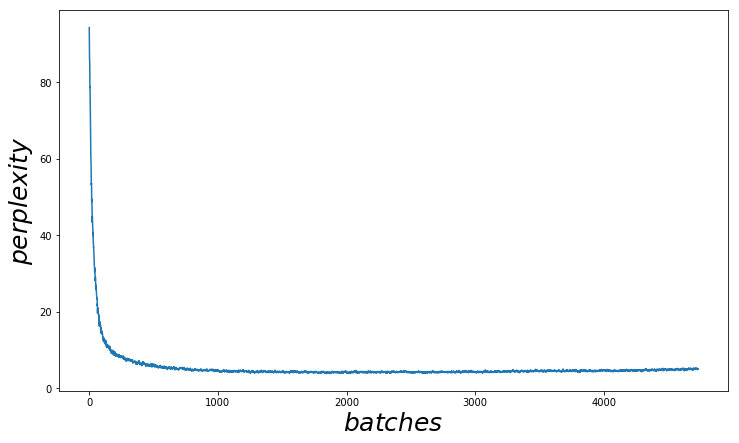

In [145]:
plt.figure(figsize=(12,7))
plt.plot(range(len(perplexity[10:])), perplexity[10:])
plt.xlabel("$batches$", fontsize=25)
plt.ylabel("$perplexity$", fontsize=25)
plt.show()

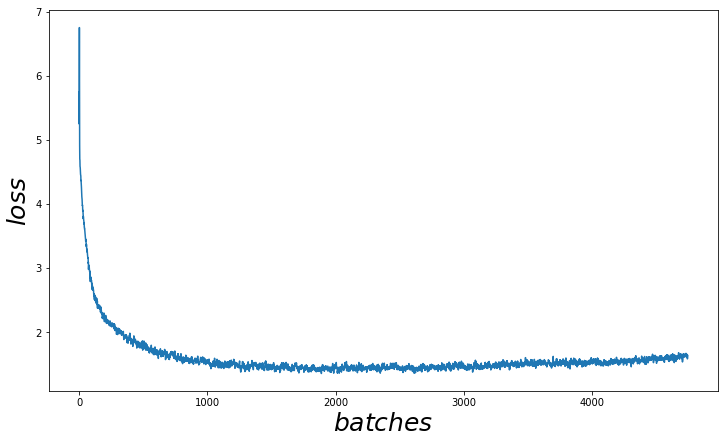

In [146]:
plt.figure(figsize=(12,7))
plt.plot(range(len(losses)), losses)
plt.xlabel("$batches$", fontsize=25)
plt.ylabel("$loss$", fontsize=25)
plt.show()

In [147]:
for i in generates:
  print(i)

a:chhage6:▁movethe▁--h:▁now,"<UNK>estas"<UNK>estas"▁at:3"5%atf3"seat▁con3"b▁b:com.oral-andan▁maycba-3"5%atf3"seat▁con3"b▁b:com.oral-andan▁maycb03h▁inn3ries7:▁their-3"5%atf3"seat▁con3"
a."neccomychmentel-3"ilagethe3":ableerest▁dar▁--3"mentmany▁in3"escomcomla7::."ableableesir7,3"▁at:3",",3"il▁fromerasb▁been:hi▁bere▁for<UNK>▁4manus,com,3".-3"esli3"▁cse3"age9▁or7▁billionf3"<UNK>▁that3hc
a:chhageon▁most▁over<UNK>.4-3",",3"il▁fromerasb3▁andaril7mentbic▁53as▁i5%en▁part4-3"age▁downagewf3"▁c▁inmentb3"▁he9al3hes503<UNK>:en-3":arer▁billion7chse43"▁movethe▁--h:3"escomcom▁could)▁".ent2."▁3▁have▁back
a▁inflation)))),3"▁at:3"esli3"▁cse3"age9▁or7▁billionf3"<UNK>▁that▁you▁lowerable5%▁are,▁0.s.ion▁treasuryist<UNK>.ation▁financial,▁0.s,3"▁at:3"▁from9c<UNK>3"escomablees)la:3"age9:▁move3hcir5%3ist<UNK>▁4man03bch▁exchange9▁other,stman▁0.<UNK>and3"


Выдает что-то левое, видимо, надо больше учить